### 1.Prepare data

In [1]:
def generate_linear(n=100):
    import numpy as np
    pts = np.random.uniform(0, 1,(n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    import numpy as np
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if(0.1*i == 0.5):
            continue
            
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(21,1)

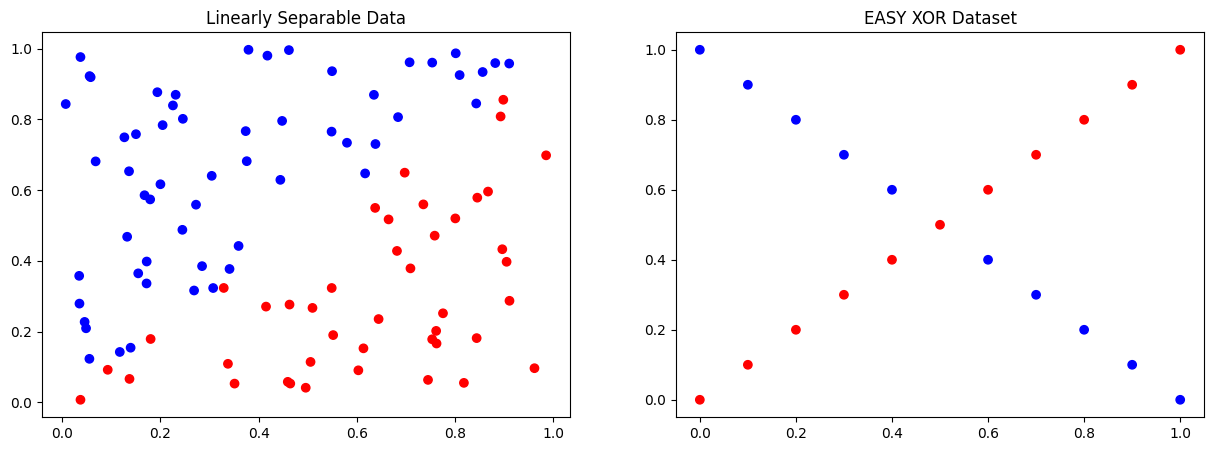

In [2]:
import matplotlib.pyplot as plt
x , y =generate_linear()
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].scatter(x[:, 0], x[:, 1], c=[ 'red' if label == 0 else 'blue' for label in y[:, 0].flatten()])
axs[0].set_title('Linearly Separable Data')

x , y =generate_XOR_easy()
axs[1].scatter(x[:, 0], x[:, 1], c=[ 'red' if label == 0 else 'blue' for label in y[:, 0].flatten()])
axs[1].set_title('EASY XOR Dataset')


plt.show()

### Create model

#### Different activation function
![Screenshot from 2024-07-15 20-47-08.png](<attachment:Screenshot from 2024-07-15 20-47-08.png>)
![Screenshot from 2024-07-15 20-45-34.png](<attachment:Screenshot from 2024-07-15 20-45-34.png>)
![Screenshot from 2024-07-15 20-45-41.png](<attachment:Screenshot from 2024-07-15 20-45-41.png>)
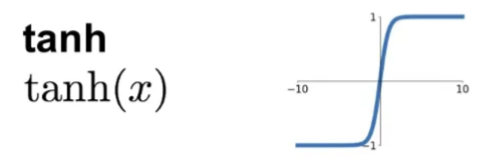
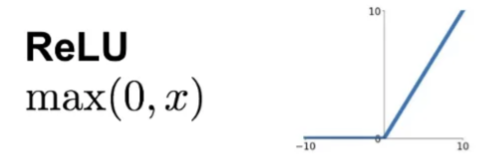
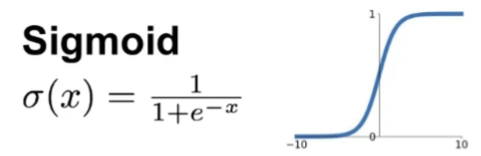

In [3]:
import numpy as np
def sigmoid(x, derivative=False):
    if derivative:
        return np.multiply(x, 1.0 - x) 
    return 1.0 / (1.0 + np.exp(-x))

def ReLU(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.where(x > 0, x, 0)

def tanh(x, derivative=False):
    if derivative:
        return 1-np.multiply(x, x)
    return np.tanh(x)

def none_activation(x, derivative=False):
    pass


#### Linear layers

In [28]:
import numpy as np


class LinearLayer:
    def __init__(self, input_size, output_size, activation):
        self.weight = np.random.randn(input_size, output_size) 
        self.bias = np.random.randn(1, output_size) * 0.01
        self.activation = activation

    def forward_pass(self, x):
        self.input = x
        self.z = np.dot(x, self.weight) + self.bias
        if self.activation != none_activation:
            self.z = self.activation(self.z)
        return self.z  

    def backward_pass(self, grad_output):
        if self.activation != none_activation:
            grad_activation = self.activation(self.z, True)
            grad_z = grad_output * grad_activation
        else:
            grad_z = grad_output  # 使用傳入的梯度
        grad_weight = np.dot(self.input.T, grad_z)
        grad_bias = np.sum(grad_z, axis=0, keepdims=True)
        grad_input = np.dot(grad_z, self.weight.T)
        return grad_input, grad_weight, grad_bias

#### MLP model
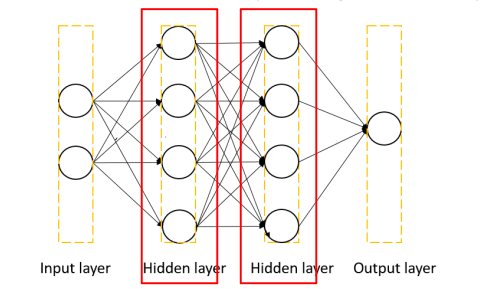

SGD 

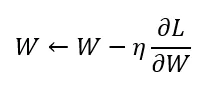

Momentum

![Pasted image.png](<attachment:Pasted image.png>)

AdaGrad

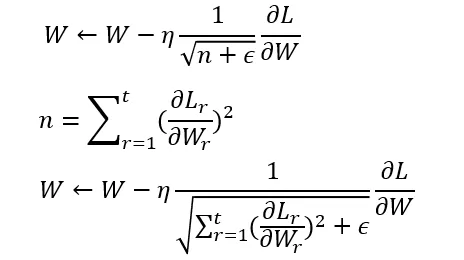

Adam

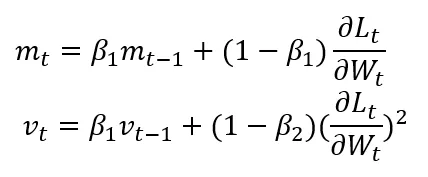

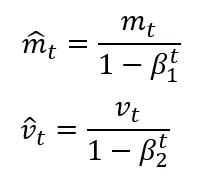

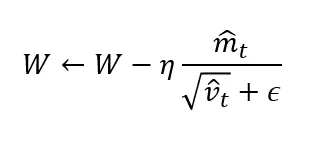
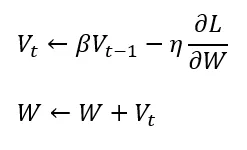

In [29]:
def MSELoss(y_hat, y, calculate_Grad = True):
    distance = np.sum((y_hat-y)**2)
    if calculate_Grad:
        return distance/y_hat.shape[0], 2*(y_hat - y)/y_hat.shape[0]
    return distance/y_hat.shape[0]
    
class MLP:
    def __init__(self, input_x, label_y, input_size=2, hidden_size=10, output_size=1, activation=sigmoid, lr=0.01, epochs=100000 ,optim='Momentum'):
        self.fc1 = LinearLayer(input_size, hidden_size, activation)
        self.fc2 = LinearLayer(hidden_size, hidden_size, activation)
        self.output = LinearLayer(hidden_size, output_size, activation)
        self.input_x = input_x
        self.label_y = label_y
        self.lr = lr
        self.activation =activation
        self.hidden_size =hidden_size
        self.epochs = epochs
        self.optim =optim
        self.loss = []

        if self.optim == "Momentum":
            self.momentum_fc1_weight = np.zeros_like(self.fc1.weight)
            self.momentum_fc1_bias = np.zeros_like(self.fc1.bias)
            self.momentum_fc2_weight = np.zeros_like(self.fc2.weight)
            self.momentum_fc2_bias = np.zeros_like(self.fc2.bias)
            self.momentum_output_weight = np.zeros_like(self.output.weight)
            self.momentum_output_bias = np.zeros_like(self.output.bias)

        elif self.optim == "Adam":
            self.m = {
                'fc1': (np.zeros_like(self.fc1.weight), np.zeros_like(self.fc1.bias)),
                'fc2': (np.zeros_like(self.fc2.weight), np.zeros_like(self.fc2.bias)),
                'output': (np.zeros_like(self.output.weight), np.zeros_like(self.output.bias)),
            }
            self.v = {
                'fc1': (np.zeros_like(self.fc1.weight), np.zeros_like(self.fc1.bias)),
                'fc2': (np.zeros_like(self.fc2.weight), np.zeros_like(self.fc2.bias)),
                'output': (np.zeros_like(self.output.weight), np.zeros_like(self.output.bias)),
            }
            self.t = 0
            self.epsilon = 1e-8
        
        elif self.optim == "Adagrad":
            self.grad_square_sum = {
                'fc1': (np.zeros_like(self.fc1.weight), np.zeros_like(self.fc1.bias)),
                'fc2': (np.zeros_like(self.fc2.weight), np.zeros_like(self.fc2.bias)),
                'output': (np.zeros_like(self.output.weight), np.zeros_like(self.output.bias)),
            }
    def forward_pass(self, x):
        x = self.fc1.forward_pass(x)
        x = self.fc2.forward_pass(x)
        output = self.output.forward_pass(x)
        return output
    
    def backward_pass(self, grad_output):
        grad_output, grad_weight_output, grad_bias_output = self.output.backward_pass(grad_output)
        grad_output, grad_weight_fc2, grad_bias_fc2 = self.fc2.backward_pass(grad_output)
        grad_output, grad_weight_fc1, grad_bias_fc1 = self.fc1.backward_pass(grad_output)
        return (grad_weight_fc1, grad_bias_fc1), (grad_weight_fc2, grad_bias_fc2), (grad_weight_output, grad_bias_output)

    def step(self, grads):
        (grad_weight_fc1, grad_bias_fc1), (grad_weight_fc2, grad_bias_fc2), (grad_weight_output, grad_bias_output) = grads
        
        if self.optim == "SGD":
            self.fc1.weight -= self.hidden * grad_weight_fc1
            self.fc1.bias -= self.lr * grad_bias_fc1
            
            self.fc2.weight -= self.lr * grad_weight_fc2
            self.fc2.bias -= self.lr * grad_bias_fc2
            
            self.output.weight -= self.lr * grad_weight_output
            self.output.bias -= self.lr * grad_bias_output

        elif self.optim == "Momentum":
            beta = 0.9  
            self.momentum_fc1_weight = beta * self.momentum_fc1_weight + grad_weight_fc1
            self.momentum_fc1_bias = beta * self.momentum_fc1_bias + grad_bias_fc1
            self.fc1.weight -= self.lr * self.momentum_fc1_weight
            self.fc1.bias -= self.lr * self.momentum_fc1_bias

            self.momentum_fc2_weight = beta * self.momentum_fc2_weight + grad_weight_fc2
            self.momentum_fc2_bias = beta * self.momentum_fc2_bias +  grad_bias_fc2
            self.fc2.weight -= self.lr * self.momentum_fc2_weight
            self.fc2.bias -= self.lr * self.momentum_fc2_bias

            self.momentum_output_weight = beta * self.momentum_output_weight + grad_weight_output
            self.momentum_output_bias = beta * self.momentum_output_bias + grad_bias_output
            self.output.weight -= self.lr * self.momentum_output_weight
            self.output.bias -= self.lr * self.momentum_output_bias
        elif self.optim == "Adam":
            self.t += 1
            
            beta1 = 0.9
            beta2 = 0.999
            
            self.m['fc1'] = (beta1 * self.m['fc1'][0] + (1 - beta1) * grad_weight_fc1, beta1 * self.m['fc1'][1] + (1 - beta1) * grad_bias_fc1)
            self.m['fc2'] = (beta1 * self.m['fc2'][0] + (1 - beta1) * grad_weight_fc2, beta1 * self.m['fc2'][1] + (1 - beta1) * grad_bias_fc2)
            self.m['output'] = (beta1 * self.m['output'][0] + (1 - beta1) * grad_weight_output, beta1 * self.m['output'][1] + (1 - beta1) * grad_bias_output)
            
            self.v['fc1'] = (beta2 * self.v['fc1'][0] + (1 - beta2) * (grad_weight_fc1 ** 2), beta2 * self.v['fc1'][1] + (1 - beta2) * (grad_bias_fc1 ** 2))
            self.v['fc2'] = (beta2 * self.v['fc2'][0] + (1 - beta2) * (grad_weight_fc2 ** 2), beta2 * self.v['fc2'][1] + (1 - beta2) * (grad_bias_fc2 ** 2))
            self.v['output'] = (beta2 * self.v['output'][0] + (1 - beta2) * (grad_weight_output ** 2), beta2 * self.v['output'][1] + (1 - beta2) * (grad_bias_output ** 2))
            
            m_hat_fc1 = (self.m['fc1'][0] / (1 - beta1 ** self.t), self.m['fc1'][1] / (1 - beta1 ** self.t))
            m_hat_fc2 = (self.m['fc2'][0] / (1 - beta1 ** self.t), self.m['fc2'][1] / (1 - beta1 ** self.t))
            m_hat_output = (self.m['output'][0] / (1 - beta1 ** self.t), self.m['output'][1] / (1 - beta1 ** self.t))
            
            v_hat_fc1 = (self.v['fc1'][0] / (1 - beta2 ** self.t), self.v['fc1'][1] / (1 - beta2 ** self.t))
            v_hat_fc2 = (self.v['fc2'][0] / (1 - beta2 ** self.t), self.v['fc2'][1] / (1 - beta2 ** self.t))
            v_hat_output = (self.v['output'][0] / (1 - beta2 ** self.t), self.v['output'][1] / (1 - beta2 ** self.t))
            
            self.fc1.weight -= self.lr * m_hat_fc1[0] / (np.sqrt(v_hat_fc1[0]) + self.epsilon)
            self.fc1.bias -= self.lr * m_hat_fc1[1] / (np.sqrt(v_hat_fc1[1]) + self.epsilon)
            
            self.fc2.weight -= self.lr * m_hat_fc2[0] / (np.sqrt(v_hat_fc2[0]) + self.epsilon)
            self.fc2.bias -= self.lr * m_hat_fc2[1] / (np.sqrt(v_hat_fc2[1]) + self.epsilon)
            
            self.output.weight -= self.lr * m_hat_output[0] / (np.sqrt(v_hat_output[0]) + self.epsilon)
            self.output.bias -= self.lr * m_hat_output[1] / (np.sqrt(v_hat_output[1]) + self.epsilon)
        
        elif self.optim == "Adagrad":
            epsilon = 1e-8
            
            self.grad_square_sum['fc1'] = (self.grad_square_sum['fc1'][0] + grad_weight_fc1**2, self.grad_square_sum['fc1'][1] + grad_bias_fc1**2)
            self.grad_square_sum['fc2'] = (self.grad_square_sum['fc2'][0] + grad_weight_fc2**2, self.grad_square_sum['fc2'][1] + grad_bias_fc2**2)
            self.grad_square_sum['output'] = (self.grad_square_sum['output'][0] + grad_weight_output**2, self.grad_square_sum['output'][1] + grad_bias_output**2)
            
            self.fc1.weight -= self.lr * grad_weight_fc1 / (np.sqrt(self.grad_square_sum['fc1'][0]) + epsilon)
            self.fc1.bias -= self.lr * grad_bias_fc1 / (np.sqrt(self.grad_square_sum['fc1'][1]) + epsilon)
            
            self.fc2.weight -= self.lr * grad_weight_fc2 / (np.sqrt(self.grad_square_sum['fc2'][0]) + epsilon)
            self.fc2.bias -= self.lr * grad_bias_fc2 / (np.sqrt(self.grad_square_sum['fc2'][1]) + epsilon)
            
            self.output.weight -= self.lr * grad_weight_output / (np.sqrt(self.grad_square_sum['output'][0]) + epsilon)
            self.output.bias -= self.lr * grad_bias_output / (np.sqrt(self.grad_square_sum['output'][1]) + epsilon)

    def train(self):
        print(f"Learning Rate: {self.lr}, Hidden Size:{self.hidden_size} Optimizer: {self.optim}, Activation: {self.activation.__name__}")
        for epoch in range(self.epochs):
            output = self.forward_pass(self.input_x)
            loss, grad_output = MSELoss(output, self.label_y)
            grads = self.backward_pass(grad_output)
            self.step(grads)
            self.loss.append(loss)

            if epoch % (self.epochs /10) == 0:
                print(f"epoch {epoch} loss : {loss}")
        

    def plot_learning_curve(self):
        plt.plot(self.loss)
        plt.title({"Learning Curve"})
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
        
    def cal_accuracy(self):
        self.prediction = self.forward_pass(self.input_x) 
        predictions = (self.prediction > 0.5).astype(int) 
        accuracy = np.mean(predictions == self.label_y)
        return accuracy

    def test(self):
        self.prediction = self.forward_pass(self.input_x) 
        for i in range(len(self.label_y)):
            print(f"Iter {i + 1} | Ground truth: {self.label_y[i]} | Prediction: {self.prediction[i]} |")
        predictions = (self.prediction > 0.5).astype(int) 

        accuracy = np.mean(predictions == self.label_y)  
        print(f"Accuracy: {accuracy * 100:.2f}%")

        fig, axs = plt.subplots(1, 2, figsize=(15,5))
        axs[0].scatter(self.input_x[:, 0], self.input_x[:, 1], c=[ 'red' if label == 0 else 'blue' for label in self.label_y[:, 0].flatten()])
        axs[0].set_title('Ground Truth')
        axs[1].scatter(self.input_x[:, 0], self.input_x[:, 1], c=[ 'red' if label == 0 else 'blue' for label in predictions[:, 0].flatten()])
        axs[1].set_title('Predicted Result')
        plt.show()
    def get_loss(self):
        return self.loss

### Experiment

Learning Rate: 0.1, Hidden Size:10 Optimizer: SGD, Activation: sigmoid
epoch 0 loss : 0.34767138787125973
epoch 10000 loss : 0.013500445065910973
epoch 20000 loss : 0.008195428646830726
epoch 30000 loss : 0.006406685199266038
epoch 40000 loss : 0.005541475924103098
epoch 50000 loss : 0.005009944123432791
epoch 60000 loss : 0.004622349893779954
epoch 70000 loss : 0.004300723703807536
epoch 80000 loss : 0.004005526457058652
epoch 90000 loss : 0.003713165728402391
Iter 1 | Ground truth: [0] | Prediction: [0.00643077] |
Iter 2 | Ground truth: [0] | Prediction: [1.58001431e-05] |
Iter 3 | Ground truth: [1] | Prediction: [0.68121349] |
Iter 4 | Ground truth: [0] | Prediction: [1.61524122e-05] |
Iter 5 | Ground truth: [0] | Prediction: [1.12266358e-05] |
Iter 6 | Ground truth: [0] | Prediction: [1.05936929e-05] |
Iter 7 | Ground truth: [0] | Prediction: [1.3607682e-05] |
Iter 8 | Ground truth: [1] | Prediction: [0.99999832] |
Iter 9 | Ground truth: [1] | Prediction: [0.9999981] |
Iter 10 | Gr

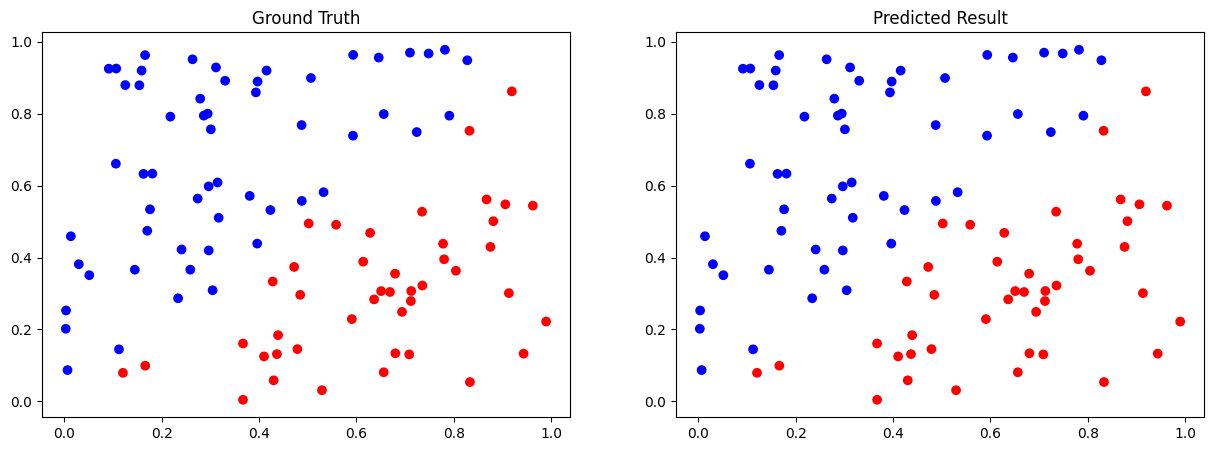

In [30]:
#test
x, y = generate_linear()
mlp = MLP(x, y , hidden_size = 10,activation=sigmoid,lr=0.1,epochs=100000,optim="SGD")
mlp.train()
mlp.test()   

Learning Rate: 0.1, Hidden Size:10 Optimizer: SGD, Activation: sigmoid
epoch 0 loss : 0.2630092739967975
epoch 10000 loss : 0.024550752768769075
epoch 20000 loss : 0.003754835520409852
epoch 30000 loss : 0.001542449149859047
epoch 40000 loss : 0.0009085491907666594
epoch 50000 loss : 0.0006273723889722081
epoch 60000 loss : 0.00047279085689709403
epoch 70000 loss : 0.00037637276835201996
epoch 80000 loss : 0.000311038934172679
epoch 90000 loss : 0.00026410386417963737
Iter 1 | Ground truth: [0] | Prediction: [0.00393233] |
Iter 2 | Ground truth: [1] | Prediction: [0.99413327] |
Iter 3 | Ground truth: [0] | Prediction: [0.00330556] |
Iter 4 | Ground truth: [1] | Prediction: [0.99459643] |
Iter 5 | Ground truth: [0] | Prediction: [0.0047796] |
Iter 6 | Ground truth: [1] | Prediction: [0.99492665] |
Iter 7 | Ground truth: [0] | Prediction: [0.01088894] |
Iter 8 | Ground truth: [1] | Prediction: [0.99415989] |
Iter 9 | Ground truth: [0] | Prediction: [0.02275222] |
Iter 10 | Ground truth: 

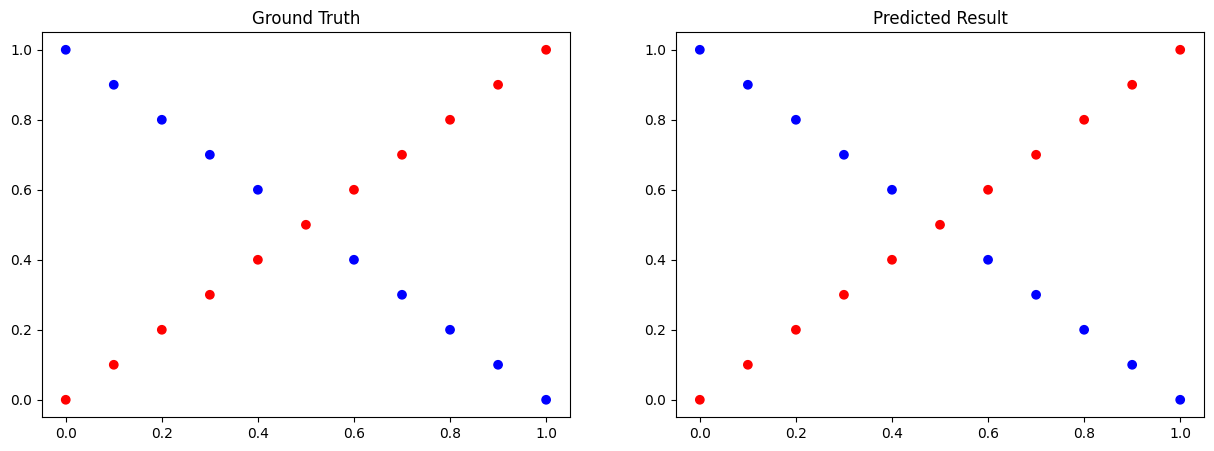

In [64]:

x, y = generate_XOR_easy()
mlp = MLP(x, y , hidden_size = 10,activation=sigmoid,lr=0.1,epochs=100000,optim="SGD")
mlp.train()
mlp.test()   

#####  1. Learning Curves for Linear Data with different optimizer and Learning Curves for XOR Data with different optimizer

Learning Rate: 0.001, Hidden Size:10 Optimizer: SGD, Activation: sigmoid
epoch 0 loss : 0.2701917586313786
epoch 10000 loss : 0.22179219097682917
epoch 20000 loss : 0.2024845477587273
epoch 30000 loss : 0.18314574972108624
epoch 40000 loss : 0.16434689553011012
epoch 50000 loss : 0.1468723488043951
epoch 60000 loss : 0.13128132905945633
epoch 70000 loss : 0.11778367891227859
epoch 80000 loss : 0.10630714603600243
epoch 90000 loss : 0.09662225410827091
Learning Rate: 0.001, Hidden Size:10 Optimizer: Momentum, Activation: sigmoid
epoch 0 loss : 0.4665791619722095
epoch 10000 loss : 0.08262857889710411
epoch 20000 loss : 0.04634030628535377
epoch 30000 loss : 0.03242817897883988
epoch 40000 loss : 0.024857343765851022
epoch 50000 loss : 0.020104065267795714
epoch 60000 loss : 0.016840955593508625
epoch 70000 loss : 0.014458415466341062
epoch 80000 loss : 0.01264003044945103
epoch 90000 loss : 0.011205689252137363
Learning Rate: 0.001, Hidden Size:10 Optimizer: Adam, Activation: sigmoid
ep

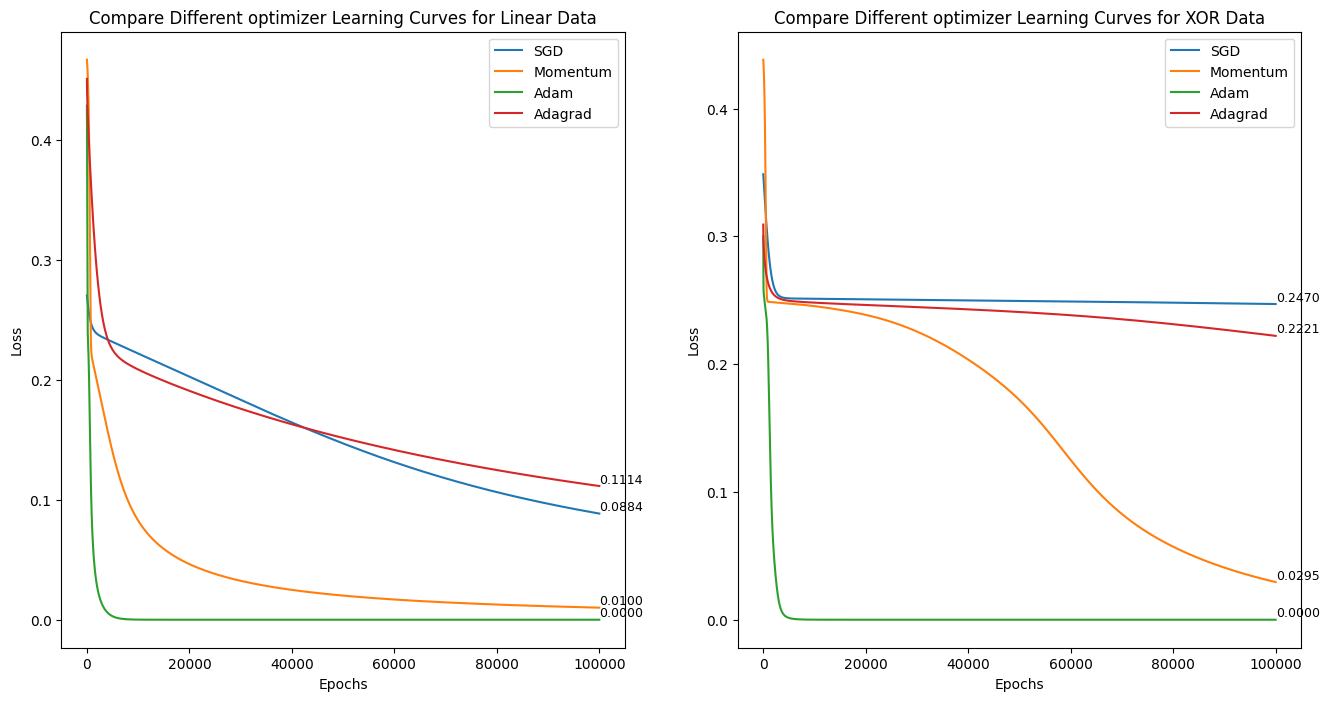

In [45]:
optimizers = ['SGD', 'Momentum', 'Adam', 'Adagrad']
learning_curves_linear = {}

x, y = generate_linear()

for optim in optimizers:
    mlp = MLP(x, y, hidden_size=10, activation=sigmoid, lr=0.001, epochs=100000, optim=optim)
    mlp.train()
    learning_curves_linear[optim] = mlp.get_loss()

learning_curves_XOR = {}

x, y = generate_XOR_easy()

for optim in optimizers:
    mlp = MLP(x, y, hidden_size=10, activation=sigmoid, lr=0.001, epochs=100000, optim=optim)
    mlp.train()
    learning_curves_XOR[optim] = mlp.get_loss()
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].set_title('Compare Different optimizer Learning Curves for Linear Data')
for optim, losses in learning_curves_linear.items():
    print(optim, losses[-1])
    axs[0].plot(losses, label=optim)
    axs[0].text(len(losses)-1, losses[-1], f"{losses[-1]:.4f}", fontsize=9, verticalalignment='bottom')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Compare Different optimizer Learning Curves for XOR Data')
for optim, losses in learning_curves_XOR.items():
    print(optim, losses[-1])
    axs[1].plot(losses, label=optim)
    axs[1].text(len(losses)-1, losses[-1], f"{losses[-1]:.4f}", fontsize=9, verticalalignment='bottom')

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()


##### 2. different learning rate

Learning Rate: 0.001, Hidden Size:10 Optimizer: SGD, Activation: sigmoid
epoch 0 loss : 0.3694259650147638
epoch 10000 loss : 0.26502534796265126
epoch 20000 loss : 0.24598894878227515
epoch 30000 loss : 0.22993575617584866
epoch 40000 loss : 0.2141740382699221
epoch 50000 loss : 0.1972384753986408
epoch 60000 loss : 0.1790571581127485
epoch 70000 loss : 0.1606783824663103
epoch 80000 loss : 0.14332624778378855
epoch 90000 loss : 0.12777480482187648
Learning Rate: 0.01, Hidden Size:10 Optimizer: SGD, Activation: sigmoid
epoch 0 loss : 0.26843750101251546
epoch 10000 loss : 0.09544923590264932
epoch 20000 loss : 0.0479157356486581
epoch 30000 loss : 0.032549626345499155
epoch 40000 loss : 0.024897322289388357
epoch 50000 loss : 0.020263037386623196
epoch 60000 loss : 0.017148913630877064
epoch 70000 loss : 0.014919345000592525
epoch 80000 loss : 0.013254461832440714
epoch 90000 loss : 0.011972882032211389
Learning Rate: 0.1, Hidden Size:10 Optimizer: SGD, Activation: sigmoid
epoch 0 los

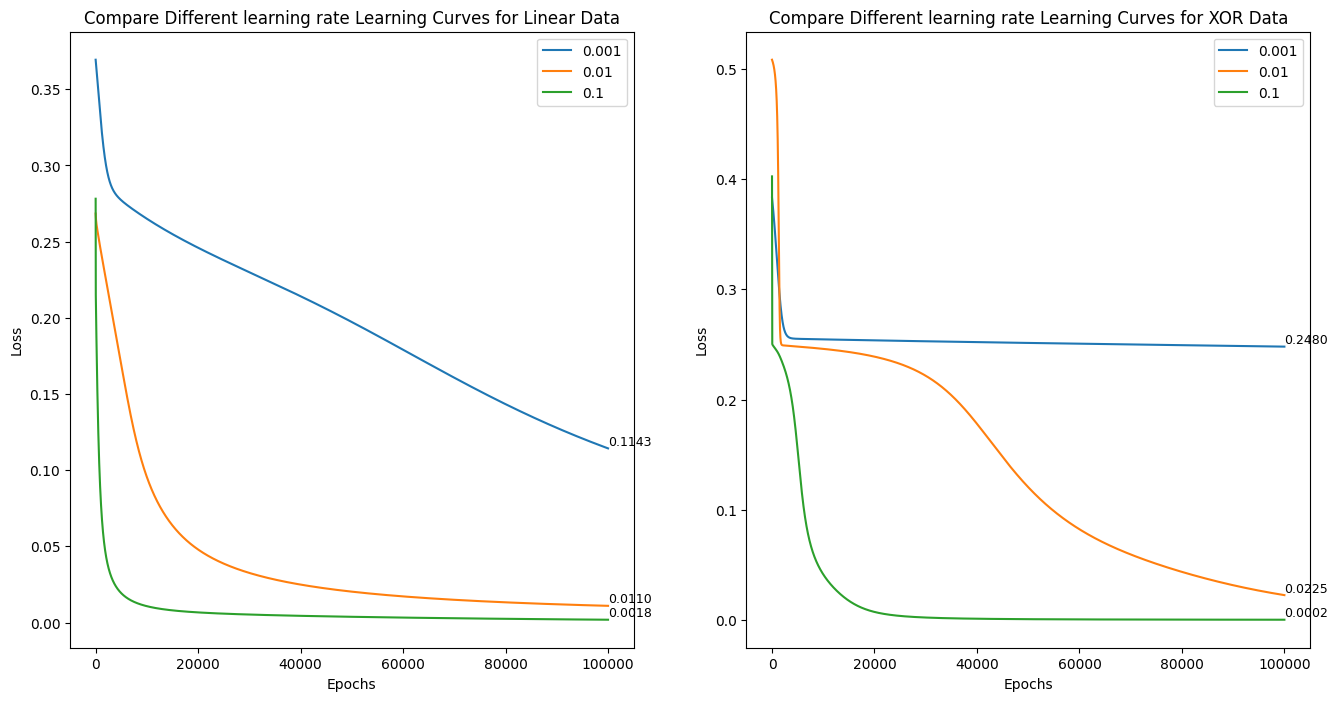

In [44]:
learning_rates = [0.001, 0.01, 0.1]
learning_curves_linear = {}
learning_curves_XOR = {}

x, y = generate_linear()

for lr in learning_rates:
    mlp = MLP(x, y, hidden_size=10, activation=sigmoid, lr=lr, epochs=100000, optim='SGD')
    mlp.train()
    learning_curves_linear[lr] = mlp.get_loss()


x, y = generate_XOR_easy()

for lr in learning_rates:
    mlp = MLP(x, y, hidden_size=10, activation=sigmoid, lr=lr, epochs=100000, optim='SGD')
    mlp.train()
    learning_curves_XOR[lr] = mlp.get_loss()
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].set_title('Compare Different learning rate Learning Curves for Linear Data')
for lr, losses in learning_curves_linear.items():
    print(lr, losses[-1])
    axs[0].plot(losses, label=lr)
    axs[0].text(len(losses)-1, losses[-1], f"{losses[-1]:.4f}", fontsize=9, verticalalignment='bottom')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Compare Different learning rate Learning Curves for XOR Data')
for lr, losses in learning_curves_XOR.items():
    print(lr, losses[-1])
    axs[1].plot(losses, label=lr)
    axs[1].text(len(losses)-1, losses[-1], f"{losses[-1]:.4f}", fontsize=9, verticalalignment='bottom')

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

##### 3.different hidden size

Learning Rate: 0.001, Hidden Size:10 Optimizer: SGD, Activation: sigmoid
epoch 0 loss : 0.28131845879706896
epoch 10000 loss : 0.21839698928361387
epoch 20000 loss : 0.20104776101329336
epoch 30000 loss : 0.18178179184484905
epoch 40000 loss : 0.1610407149755731
epoch 50000 loss : 0.14015555981631317
epoch 60000 loss : 0.12075548720291569
epoch 70000 loss : 0.10397520054375814
epoch 80000 loss : 0.09014993500088776
epoch 90000 loss : 0.07904645585599872
Learning Rate: 0.001, Hidden Size:20 Optimizer: SGD, Activation: sigmoid
epoch 0 loss : 0.4304528045728169
epoch 10000 loss : 0.1966861008465212
epoch 20000 loss : 0.14814438284251147
epoch 30000 loss : 0.11555126978249548
epoch 40000 loss : 0.09421245287858826
epoch 50000 loss : 0.07972479613005484
epoch 60000 loss : 0.06951375401710348
epoch 70000 loss : 0.06203669361090946
epoch 80000 loss : 0.05635420733486736
epoch 90000 loss : 0.05188743146745109
Learning Rate: 0.001, Hidden Size:30 Optimizer: SGD, Activation: sigmoid
epoch 0 loss

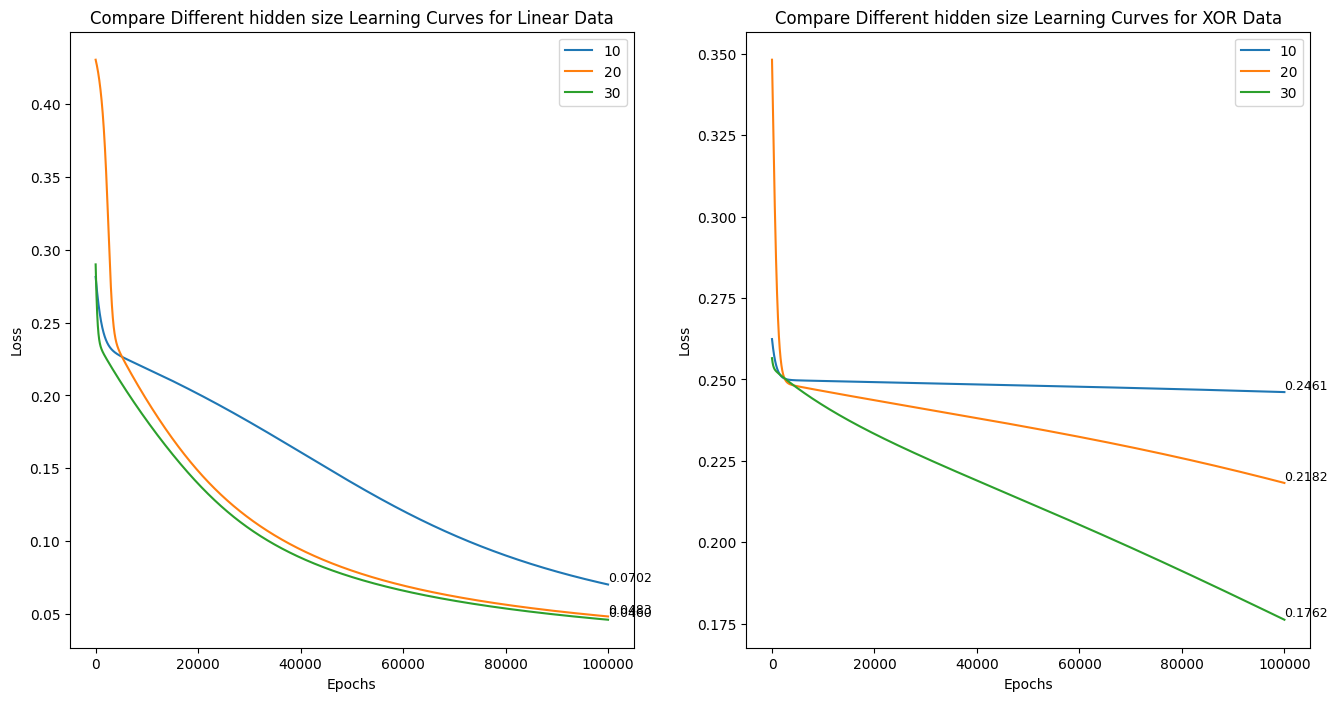

In [51]:
hidden_units = [10, 20, 30]
learning_curves_linear = {}
learning_curves_XOR = {}

x, y = generate_linear()

for hidden in hidden_units:
    mlp = MLP(x, y, hidden_size=hidden, activation=sigmoid, lr=0.001, epochs=100000, optim='SGD')
    mlp.train()
    learning_curves_linear[hidden] = mlp.get_loss()


x, y = generate_XOR_easy()

for hidden in hidden_units:
    mlp = MLP(x, y, hidden_size=hidden, activation=sigmoid, lr=0.001, epochs=100000, optim='SGD')
    mlp.train()
    learning_curves_XOR[hidden] = mlp.get_loss()
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].set_title('Compare Different hidden size Learning Curves for Linear Data')
for hidden, losses in learning_curves_linear.items():
    print(hidden, losses[-1])
    axs[0].plot(losses, label=hidden)
    axs[0].text(len(losses)-1, losses[-1], f"{losses[-1]:.4f}", fontsize=9, verticalalignment='bottom')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Compare Different hidden size Learning Curves for XOR Data')
for hidden, losses in learning_curves_XOR.items():
    print(hidden, losses[-1])
    axs[1].plot(losses, label=hidden)
    axs[1].text(len(losses)-1, losses[-1], f"{losses[-1]:.4f}", fontsize=9, verticalalignment='bottom')

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

##### 4.different activation

Learning Rate: 0.001, Hidden Size:10 Optimizer: SGD, Activation: sigmoid
epoch 0 loss : 0.39910996951353206
epoch 10000 loss : 0.24190009890721156
epoch 20000 loss : 0.23279275015239034
epoch 30000 loss : 0.2228915632194761
epoch 40000 loss : 0.2116086544791679
epoch 50000 loss : 0.19864555277415546
epoch 60000 loss : 0.1840285155398582
epoch 70000 loss : 0.1681939359886917
epoch 80000 loss : 0.15195797587349036
epoch 90000 loss : 0.13630196865845662
Learning Rate: 0.001, Hidden Size:10 Optimizer: SGD, Activation: ReLU
epoch 0 loss : 5.792057290765846
epoch 10000 loss : 0.01580519813834262
epoch 20000 loss : 0.01151581097332058
epoch 30000 loss : 0.009753222403187139
epoch 40000 loss : 0.00826896266075975
epoch 50000 loss : 0.006980451180590168
epoch 60000 loss : 0.0059105984322487155
epoch 70000 loss : 0.005061040124611746
epoch 80000 loss : 0.0043900298197156445
epoch 90000 loss : 0.003860323208325767
Learning Rate: 0.001, Hidden Size:10 Optimizer: SGD, Activation: tanh
epoch 0 loss 

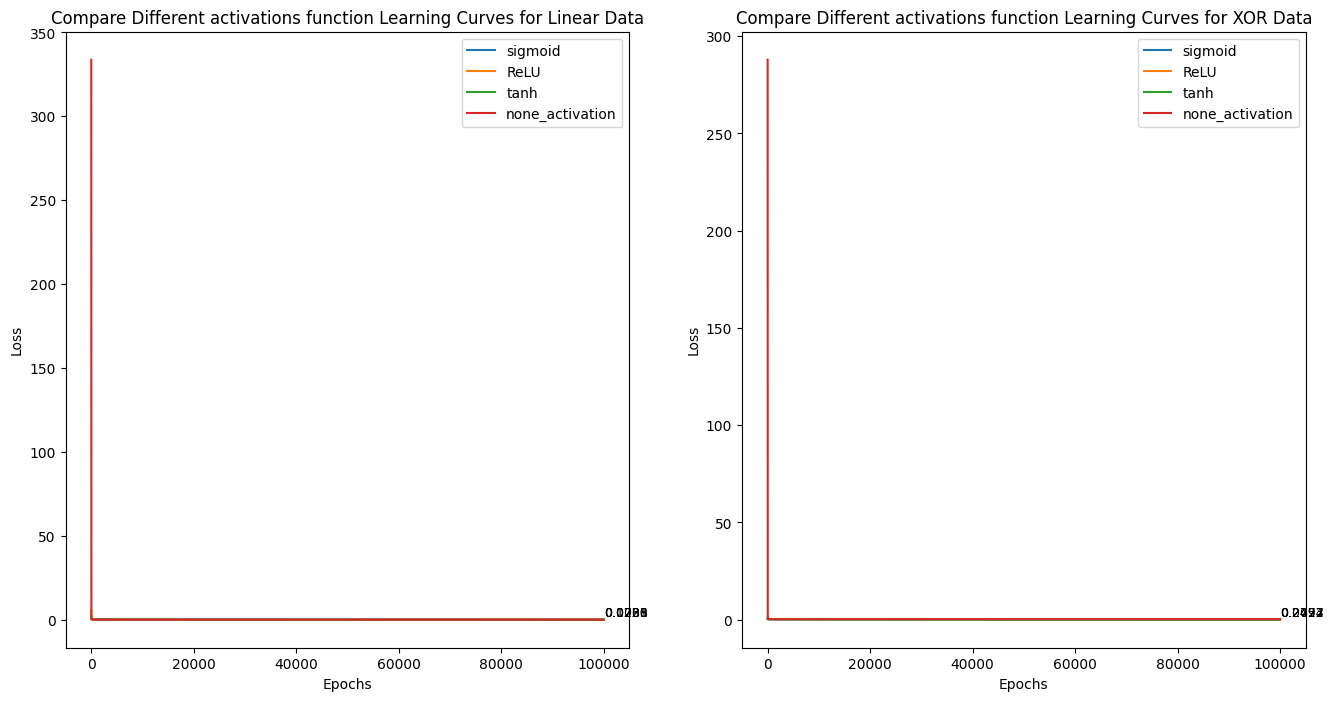

In [57]:
activations = [sigmoid, ReLU, tanh, none_activation]
learning_curves_linear = {}
learning_curves_XOR = {}

x, y = generate_linear()

for activate in activations:
    mlp = MLP(x, y, hidden_size=10, activation=activate, lr=0.001, epochs=100000, optim='SGD')
    mlp.train()
    learning_curves_linear[activate] = mlp.get_loss()


x, y = generate_XOR_easy()

for activate in activations:
    mlp = MLP(x, y, hidden_size=10, activation=activate, lr=0.001, epochs=100000, optim='SGD')
    mlp.train()
    learning_curves_XOR[activate] = mlp.get_loss()
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].set_title('Compare Different activations function Learning Curves for Linear Data')
for activate, losses in learning_curves_linear.items():
    print(activate.__name__, losses[-1])
    axs[0].plot(losses, label=activate.__name__)
    axs[0].text(len(losses)-1, losses[-1], f"{losses[-1]:.4f}", fontsize=9, verticalalignment='bottom')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Compare Different activations function Learning Curves for XOR Data')
for activate, losses in learning_curves_XOR.items():
    print(activate.__name__, losses[-1])
    axs[1].plot(losses, label=activate.__name__)
    axs[1].text(len(losses)-1, losses[-1], f"{losses[-1]:.4f}", fontsize=9, verticalalignment='bottom')

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

##### 5.detail experiment

In [62]:
# 實驗設置
learning_rates = [0.001, 0.01, 0.1]
optimizers = ['SGD', 'Momentum','Adagrad' ,'Adam']
activations = [sigmoid, ReLU, tanh, none_activation]
hidden_sizes = [10, 20, 30]
functions = [generate_linear, generate_XOR_easy]

import pandas as pd

# 儲存實驗結果的列表
results = []

# 進行實驗
for func in functions:
    print(f"Function: {func.__name__} ")
    x, y = func()
    for lr in learning_rates:
        for optimizer in optimizers:
            for activation in activations:
                for hidden_size in hidden_sizes:
                    mlp = MLP(x, y, hidden_size=hidden_size, activation=activation, lr=lr, optim=optimizer)
                    mlp.train()
                    final_loss = mlp.loss[-1]
                    accurcy = mlp.cal_accuracy()
                    print(f"Final loss:{final_loss} Accurcy:{accurcy}")
                    results.append({
                        'Function': func.__name__,
                        'Learning Rate': lr,
                        'Optimizer': optimizer,
                        'Activation': activation.__name__,
                        'Hidden Size': hidden_size,
                        'Final Loss': final_loss,
                        "Accurcy": accurcy
                    })

results_df = pd.DataFrame(results)

Function: generate_linear 
Learning Rate: 0.001, Hidden Size:10 Optimizer: SGD, Activation: sigmoid
epoch 0 loss : 0.5809446545229385
epoch 10000 loss : 0.5691997121793729
epoch 20000 loss : 0.35518591731410226
epoch 30000 loss : 0.23800057998955662
epoch 40000 loss : 0.23378581487182284
epoch 50000 loss : 0.22907671668440133
epoch 60000 loss : 0.22362605729049928
epoch 70000 loss : 0.21720749741695614
epoch 80000 loss : 0.2096007077466138
epoch 90000 loss : 0.20062104640240638
Final loss:0.19017807346409213 Accurcy:0.81
Learning Rate: 0.001, Hidden Size:20 Optimizer: SGD, Activation: sigmoid
epoch 0 loss : 0.5828333209556374
epoch 10000 loss : 0.5614453642918328
epoch 20000 loss : 0.20554857587602737
epoch 30000 loss : 0.18021336365170942
epoch 40000 loss : 0.15824369614800296
epoch 50000 loss : 0.13970445048136731
epoch 60000 loss : 0.12366550379700932
epoch 70000 loss : 0.1098060013573802
epoch 80000 loss : 0.09806248110732993
epoch 90000 loss : 0.08831016120120445
Final loss:0.0803

/tmp/ipykernel_88137/1728828950.py:2: RuntimeWarning: overflow encountered in square
  distance = np.sum((y_hat-y)**2)


epoch 10000 loss : nan
epoch 20000 loss : nan
epoch 30000 loss : nan
epoch 40000 loss : nan
epoch 50000 loss : nan
epoch 60000 loss : nan
epoch 70000 loss : nan
epoch 80000 loss : nan
epoch 90000 loss : nan
Final loss:nan Accurcy:0.41
Learning Rate: 0.01, Hidden Size:20 Optimizer: SGD, Activation: none_activation
epoch 0 loss : 25.941221520634098
epoch 10000 loss : nan
epoch 20000 loss : nan
epoch 30000 loss : nan
epoch 40000 loss : nan
epoch 50000 loss : nan
epoch 60000 loss : nan
epoch 70000 loss : nan
epoch 80000 loss : nan
epoch 90000 loss : nan
Final loss:nan Accurcy:0.41
Learning Rate: 0.01, Hidden Size:30 Optimizer: SGD, Activation: none_activation
epoch 0 loss : 306.95692303264246
epoch 10000 loss : nan
epoch 20000 loss : nan
epoch 30000 loss : nan
epoch 40000 loss : nan
epoch 50000 loss : nan
epoch 60000 loss : nan
epoch 70000 loss : nan
epoch 80000 loss : nan
epoch 90000 loss : nan
Final loss:nan Accurcy:0.41
Learning Rate: 0.01, Hidden Size:10 Optimizer: Momentum, Activation

/home/aiden/miniconda3/envs/torch/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch 10000 loss : nan
epoch 20000 loss : nan
epoch 30000 loss : nan
epoch 40000 loss : nan
epoch 50000 loss : nan
epoch 60000 loss : nan
epoch 70000 loss : nan
epoch 80000 loss : nan
epoch 90000 loss : nan
Final loss:nan Accurcy:0.41
Learning Rate: 0.1, Hidden Size:10 Optimizer: Momentum, Activation: sigmoid
epoch 0 loss : 0.28927754026795155
epoch 10000 loss : 0.0005720310966171302
epoch 20000 loss : 0.00017649560823939736
epoch 30000 loss : 9.6608646954549e-05
epoch 40000 loss : 6.446595554828487e-05
epoch 50000 loss : 4.7571527787532085e-05
epoch 60000 loss : 3.730953263662141e-05
epoch 70000 loss : 3.0479899406761023e-05
epoch 80000 loss : 2.5638623464053165e-05
epoch 90000 loss : 2.204450540844753e-05
Final loss:1.9280581139972748e-05 Accurcy:1.0
Learning Rate: 0.1, Hidden Size:20 Optimizer: Momentum, Activation: sigmoid
epoch 0 loss : 0.19243224253018518
epoch 10000 loss : 0.0005427784104842082
epoch 20000 loss : 0.00017289038257128537
epoch 30000 loss : 9.433975536846033e-05
ep

In [63]:
results_df.to_csv('result.csv', index=False)